Instead of sampling points on the manifold a greater number of sample can be found by sampling each point on the trajectory. That is because in order to sample the velocity at some point on the surface we need to calculate its trajectory anyways. Storing as tuples that exist on the surface. Starting at apogee and backpropagating for a range of Cb values, place bounds on x and xdot

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from scipy import interpolate

In [2]:
def get_gravity(altitude_ASL):
    """
    Returns gravitational acceleration as a function of altitude above sea level (ASL).
    This function approximates Earth's gravity assuming a perfect sphere.

    Parameters:
    altitude_ASL (float): Altitude above sea level in meters.

    Returns:
    float: Gravitational acceleration at the given altitude in m/s².
    """

    g_0 = -9.80665  # Standard gravity at sea level (m/s²)
    R_e = 6371000  # Earth's radius in meters

    # Gravity decreases with altitude according to the inverse-square law
    g = g_0 * (R_e / (R_e + altitude_ASL)) ** 2
    
    return g
def get_air_density(altitude_ASL):
    """
    Returns air density as a function of altitude above sea level (ASL).
    This is valid up to an altitude of 11 kilometers, and it uses the barometric formula
    assuming a constant temperature lapse rate in the troposphere.

    Parameters:
    altitude_ASL (float): Altitude above sea level in meters.

    Returns:
    float: Air density at the given altitude in kg/m³.
    """

    p_0 = 101325  # Standard sea level atmospheric pressure in Pascals
    M = 0.0289652  # Molar mass of dry air in kg/mol
    R = 8.31445  # Universal gas constant in J/(mol·K)
    T_0 = 288.15  # Standard sea level temperature in Kelvin
    L = 0.0065  # Temperature lapse rate in K/m

    # Get gravity at the specified altitude
    g = get_gravity(altitude_ASL)

    # Calculate the air density using the barometric formula
    rho = (p_0 * M) / (R * T_0) * (1 - (L * altitude_ASL) / T_0) ** (((-g * M) / (R * L)) - 1)

    return rho
def ballistic_flight_model(x):
    # Get gravitational acceleration and air density at current altitude (x[0] is altitude)
    g = get_gravity(x[0])
    rho = get_air_density(x[0])

    dx = np.zeros_like(x) 
    
    dx[0] = x[1]
    dx[1] = g - (rho * x[1]**2) / (2 * x[2])
    dx[2] = 0
    
    return dx

def rk4(dynamics, x, dt):
    """
    Perform a single step of the Runge-Kutta 4th order integration.

    :param dynamics: The dynamics function (e.g., ballistic_flight_model).
    :param x: The current state vector.
    :param dt: The timestep.
    :return: The updated state vector.
    """
    # Compute the intermediate slopes k1, k2, k3, k4
    k1 = dt * dynamics(x)
    k2 = dt * dynamics(x + 0.5 * k1)
    k3 = dt * dynamics(x + 0.5 * k2)
    k4 = dt * dynamics(x + k3)
    
    # Compute the next state
    x_next = x + (k1 + 2*k2 + 2*k3 + k4) / 6
    
    return x_next

def f(reference_apogee, ballistic_coefficient):
        velocity_bound = 300

        dt = -0.5   
        crop = 5

        velocity = 0
        altitude = reference_apogee
        ballistic_coefficient = ballistic_coefficient

        velocities = []
        altitudes = []
        ballistic_coefficients = []

        x = np.zeros((3, 1))
        x[0, 0] = altitude  # Initial altitude
        x[1, 0] = velocity  # Initial velocity
        x[2, 0] = ballistic_coefficient  # Set current Cb estimate

        while x[1,0] < velocity_bound and x[0,0] > 0:

            x = rk4(ballistic_flight_model, x, dt)

            altitudes.append(x[0,0])
            velocities.append(x[1,0])
            ballistic_coefficients.append(x[2,0])
        

        return altitudes[int(-crop/dt):], velocities[int(-crop/dt):], ballistic_coefficients[int(-crop/dt):]
    

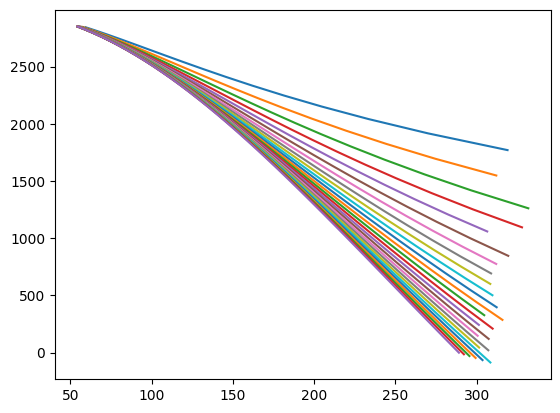

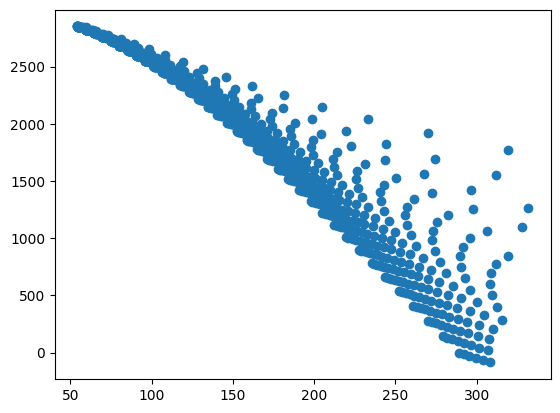

In [3]:
# Initialise the lists for storing the training data
all_altitudes = []
all_velocities = []
all_ballistic_coefficients = []


Cb_inputs = np.linspace(500, 5000, 25) # No of lines


for Cb in Cb_inputs:
    [new_altitudes, new_velocities, new_ballistic_coefficients] = f(3000, Cb)
    all_altitudes.extend(new_altitudes)
    all_velocities.extend(new_velocities)
    all_ballistic_coefficients.extend(new_ballistic_coefficients)

    plt.plot(new_velocities, new_altitudes)

plt.show()

plt.scatter(all_velocities, all_altitudes)

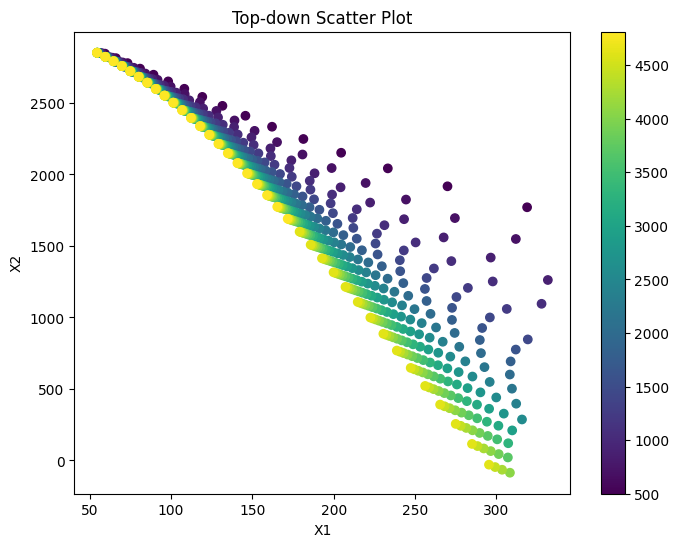

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming the following arrays are defined elsewhere
x1 = np.array(all_velocities)
x2 = np.array(all_altitudes)
y = np.array(all_ballistic_coefficients)

x1_origin = x1
x2_origin = x2
y_origin = y

# Step 1: Ensure the total number of elements is a perfect square
perfect_square_size = int(np.sqrt(len(x1_origin)))**2

# Step 2: Truncate arrays to the perfect square size
x1_origin = x1_origin[:perfect_square_size]
x2_origin = x2_origin[:perfect_square_size]
y_origin = y_origin[:perfect_square_size]

# Step 3: Calculate the new axis length after truncation
axis_length = int(np.sqrt(len(x1_origin)))

# Step 4: Reshape into a 2D grid
x1_mesh_o = x1_origin.reshape(axis_length, axis_length)
x2_mesh_o = x2_origin.reshape(axis_length, axis_length)
y_mesh_o = y_origin.reshape(axis_length, axis_length)

# Step 5: Plotting the top-down contour plot
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot, use x1_mesh_o, x2_mesh_o for the positions, and color by y_mesh_o
scatter = ax.scatter(x1_mesh_o, x2_mesh_o, c=y_mesh_o, cmap='viridis')

# Add colorbar to show the color scale
plt.colorbar(scatter, ax=ax)

# Optionally, set labels for clarity
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_title('Top-down Scatter Plot')

plt.show()



# Normalize inputs to the range [0, 1]
x1_norm = (x1 - np.min(x1)) / (np.max(x1) - np.min(x1))
x2_norm = (x2 - np.min(x2)) / (np.max(x2) - np.min(x2))

X = np.stack([x1_norm, x2_norm], axis=1)
y = y.reshape(-1, 1)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)





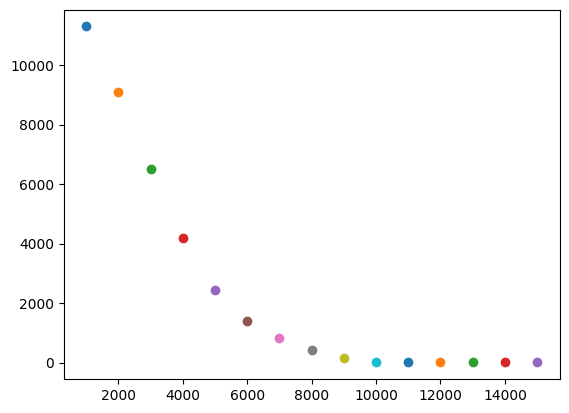

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.neighbors import KernelDensity
import numpy as np

# Define the improved neural network
class ImprovedNeuralNet(nn.Module):
    def __init__(self):
        super(ImprovedNeuralNet, self).__init__()
        # Increase network depth and width
        self.fc1 = nn.Linear(2, 128)  # Larger first layer
        self.fc2 = nn.Linear(128, 64)  # Second layer
        self.fc3 = nn.Linear(64, 32)   # Third layer
        self.fc4 = nn.Linear(32, 1)    # Output layer
        
        # Optional: Add Batch Normalization
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.batch_norm3 = nn.BatchNorm1d(32)
        
        # LeakyReLU layers
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)

    def forward(self, x):
        # Using LeakyReLU activation with BatchNorm after each hidden layer
        x = self.leaky_relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.leaky_relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.leaky_relu(self.fc3(x))
        x = self.batch_norm3(x)
        x = self.fc4(x)  # Output layer
        return x

# Define the custom weighted MSE loss function
class WeightedMSELoss(nn.Module):
    def __init__(self, weights):
        super(WeightedMSELoss, self).__init__()
        self.weights = weights

    def forward(self, outputs, targets):
        # Compute element-wise squared differences
        loss = (outputs - targets) ** 2
        # Weight each data point by its weight
        weighted_loss = self.weights * loss.squeeze()
        return weighted_loss.mean()

# Example training data (replace this with your actual data)
# Assuming all_velocities and all_altitudes are the input features
# Assuming targets are the ground truth values (y_train)

# Example data
X_train = torch.tensor(np.vstack([all_velocities, all_altitudes]).T, dtype=torch.float32)
y_train = torch.tensor(all_ballistic_coefficients, dtype=torch.float32).view(-1, 1)

# Compute KDE for weights
X_train_np = X_train.numpy()  # Convert tensor to NumPy for KDE
kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_train_np)

# Get density scores (logarithmic) for each point
log_density = kde.score_samples(X_train_np)
density = np.exp(log_density)

# Compute weights inversely proportional to density
weights = 1 / density
weights /= np.sum(weights)  # Normalize weights

# Convert weights to a tensor
weights_tensor = torch.tensor(weights, dtype=torch.float32).to(X_train.device)

# Initialize the model, loss function, and optimizer
model = ImprovedNeuralNet()
criterion = WeightedMSELoss(weights=weights_tensor)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 15000
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()  # Zero the gradients

    outputs = model(X_train)  # Forward pass
    loss = criterion(outputs, y_train)  # Compute weighted loss
    loss.backward()  # Backpropagation
    optimizer.step()  # Update weights

    # Print the loss every 1000 epochs
    if (epoch + 1) % 1000 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}", end="\r")
        plt.scatter(epoch, loss.item())

plt.show()
# Save the model if needed
torch.save(model.state_dict(), "improved_model_with_kde_weights.pth")


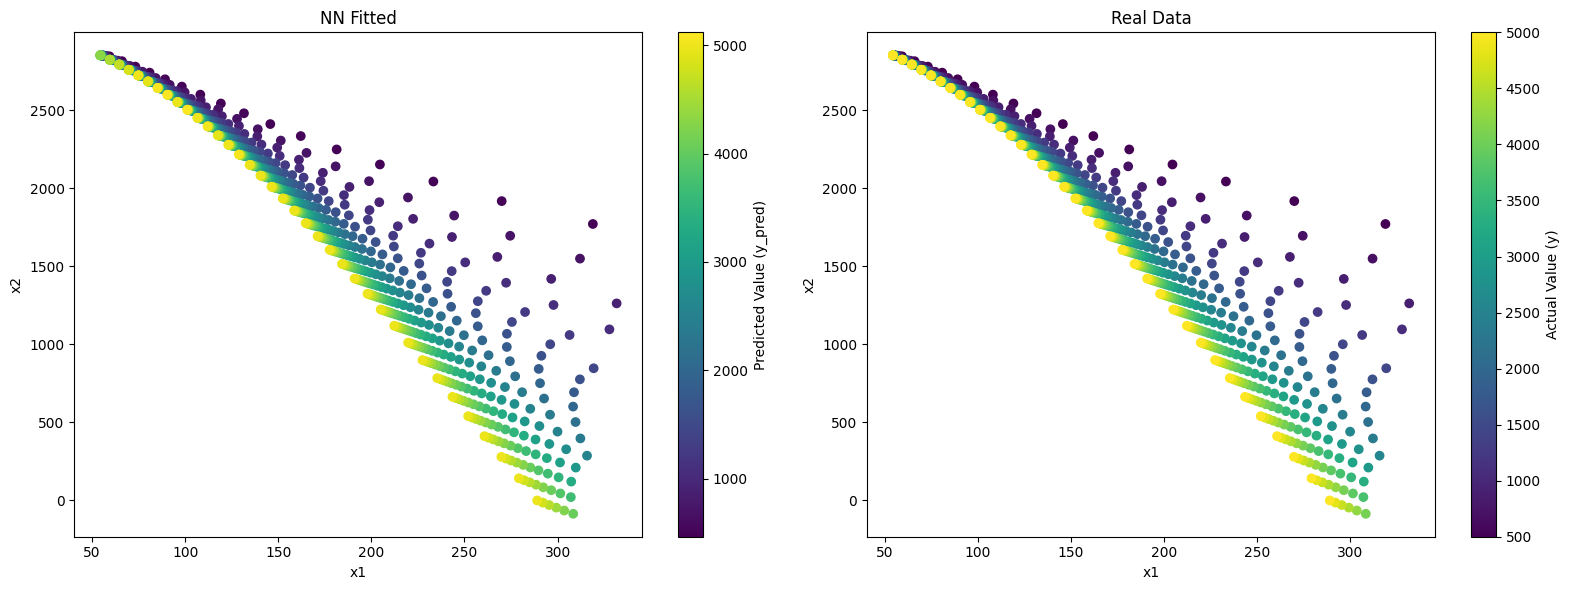

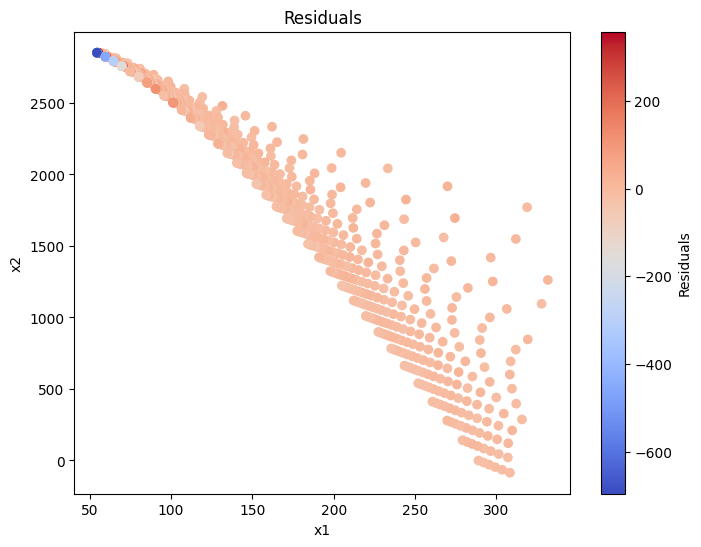

In [6]:
# Example discrete points in x1_array and x2_array
x1_array = x1#np.array([0.1, 0.2, 0.3, 0.4])  # Replace with your x1 values
x2_array = x2#np.array([0.5, 0.6, 0.7, 0.8])  # Replace with your x2 values

# Stack the x1_array and x2_array to form a 2D array of points (each row is a point [x1, x2])
x_points = np.column_stack((x1_array, x2_array))

# Convert the points to a tensor (assuming your model expects a tensor input)
X_tensor = torch.tensor(x_points, dtype=torch.float32)

# Evaluate y_pred at each of these points using the model (assuming your model is a PyTorch model)
y_pred = model(X_tensor).detach().numpy()

# Calculate the residuals
residuals = y_pred - y


# Assuming x_points, y_pred, and y are already defined

# Calculate the residuals
residuals = y_pred - y

# Create a figure with two subplots side by side for the scatter plots
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: NN fitted (Predicted vs. x1, x2)
scatter1 = ax[0].scatter(x_points[:, 0], x_points[:, 1], c=y_pred, cmap='viridis')
fig.colorbar(scatter1, ax=ax[0], label='Predicted Value (y_pred)')
ax[0].set_xlabel('x1')
ax[0].set_ylabel('x2')
ax[0].set_title('NN Fitted')

# Plot 2: Real Data (Actual vs. x1, x2)
scatter2 = ax[1].scatter(x_points[:, 0], x_points[:, 1], c=y, cmap='viridis')
fig.colorbar(scatter2, ax=ax[1], label='Actual Value (y)')
ax[1].set_xlabel('x1')
ax[1].set_ylabel('x2')
ax[1].set_title('Real Data')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the first figure (scatter plots)
plt.show()

# Create a separate figure for the residuals
plt.figure(figsize=(8, 6))

# Plot 3: Residuals (Residuals vs. x1, x2)
scatter3 = plt.scatter(x_points[:, 0], x_points[:, 1], c=residuals, cmap='coolwarm')
plt.colorbar(scatter3, label='Residuals')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Residuals')

# Show the residuals plot
plt.show()





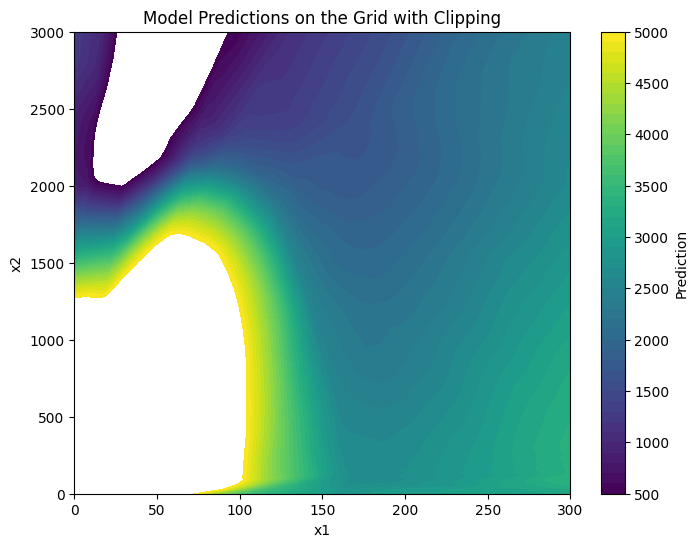

In [7]:
# Generate the grid of x1 and x2 values
x1_array = np.linspace(0, 300, 2000)  # 100 points from 0 to 300 for x1
x2_array = np.linspace(0, 3000, 2000)  # 100 points from 0 to 3000 for x2

# Create a 2D grid of x1 and x2 values
x1_grid, x2_grid = np.meshgrid(x1_array, x2_array)

# Flatten the grid to form a list of points [[x1, x2], [x1, x2], ...]
x1_flat = x1_grid.ravel()
x2_flat = x2_grid.ravel()

# Stack the flattened arrays to create a 2D array of points
x_points = np.column_stack((x1_flat, x2_flat))

# Convert the points to a tensor
X_tensor = torch.tensor(x_points, dtype=torch.float32)

# Evaluate the model to get predictions for each point
# Assuming `model` is your PyTorch model
y_pred = model(X_tensor).detach().numpy()

# Set upper and lower bounds for y_pred
y_min, y_max = 500, 5000 # Replace with your desired bounds
y_pred_clipped = np.where((y_pred >= y_min) & (y_pred <= y_max), y_pred, np.nan)

# Reshape the predictions to match the grid shape for plotting
y_pred_grid = y_pred_clipped.reshape(x1_grid.shape)

# Plot the results
plt.figure(figsize=(8, 6))
plt.contourf(x1_grid, x2_grid, y_pred_grid, levels=50, cmap='viridis')
plt.colorbar(label='Prediction')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Model Predictions on the Grid with Clipping')
plt.show()


In [ ]:
def evaluate_model_at_point(x1, x2, model):
    """
    Evaluates the neural network model at a single point (x1, x2).
    
    Args:
    - x1 (float): The value for x1 input.
    - x2 (float): The value for x2 input.
    - model (torch.nn.Module): The neural network model.
    
    Returns:
    - float: The model's prediction at the given point (x1, x2).
    """
    # Ensure the input matches the expected dimensions of the model
    x_point = torch.tensor([[x1, x2]], dtype=torch.float32)  # Shape should be (1, 2) for a 2D input
    
    # Pass the input through the model and get the prediction
    model.eval()  # Make sure the model is in evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference     
        y_pred = model(x_point).detach().numpy()  # Get prediction as numpy array
    
    return y_pred[0][0]  # Return the prediction

# Example usage:
# Assuming `model` is already defined and trained, for instance:
# model = YourModel()

x1_input = 250  # Example input for x1
x2_input = 2000  # Example input for x2

prediction = evaluate_model_at_point(x1_input, x2_input, model)
print(f"Prediction at (x1={x1_input}, x2={x2_input}): {prediction}")


Prediction at (x1=250, x2=1000): 3460.385498046875
